In [1]:
%matplotlib inline

import datetime
import matplotlib.pyplot as plt
import matplotlib
import xarray as xr
import numpy as np
import pandas as pd
import s3fs
import fsspec
import dask
from dask.distributed import performance_report, Client, progress

from eofs.xarray import Eof
import cartopy.crs as ccrs
import cartopy.feature as cfeature

In [2]:
# Start dask client
client = Client()
client

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: http://127.0.0.1:8787/status,
Dashboard: http://127.0.0.1:8787/status,Workers: 4
Total threads: 8,Total memory: 8.00 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:52763,Workers: 4
Dashboard: http://127.0.0.1:8787/status,Total threads: 8
Started: Just now,Total memory: 8.00 GiB
Comm: tcp://127.0.0.1:52789,Total threads: 2
Dashboard: http://127.0.0.1:52790/status,Memory: 2.00 GiB
Nanny: tcp://127.0.0.1:52768,


# Problem 1

### Create SST Dataset

In [3]:
base_url = 'https://rda.ucar.edu/thredds/dodsC/files/g/ds633.1_nc/e5.moda.an.sfc/'
base_url2 = '/e5.moda.an.sfc.128_034_sstk.ll025sc.'
base_url3 = '.nc'

# Set range of dates to retrieve data for
pr = pd.date_range(start='1979-01',end='2021-12', freq='AS')

# Generate names for each file to be retrieved
file_list=[]
for dt in pr:
    year = dt.strftime('%Y')
    month = dt.strftime('%Y%m%d%H')
    month2 = (dt + pd.DateOffset(months=11)).strftime('%Y%m%d%H')

    # Create full file name
    single_file=(base_url+year+base_url2+month+'_'+month2+base_url3)
    
    file_list.append(single_file)

In [4]:
# Access data from the THREDDS server
ds_SST = xr.open_mfdataset(file_list, parallel=True, engine='netcdf4').sel(
                        latitude=slice(65, -65, 4),
                        longitude=slice(120, 300, 4)).compute()

In [5]:
# Create dataset grouped by month
gb_SST = ds_SST.SSTK.groupby('time.month')

In [6]:
# Calculate SST anomlies by subtracting the monthly mean from each month
anom_SST = gb_SST - gb_SST.mean('time')

### Create Precip Dataset

In [12]:
base_url = 'https://rda.ucar.edu/thredds/dodsC/files/g/ds633.1_nc/e5.moda.fc.sfc.accumu/'
base_url2 = '/e5.moda.fc.sfc.accumu.128_228_tp.ll025sc.'
base_url3 = '.nc'

# Set range of dates to retrieve data for
pr = pd.date_range(start='1979-01',end='2021-12', freq='AS')

# Generate names for each file to be retrieved
file_list=[]
for dt in pr:
    year = dt.strftime('%Y')
    month = dt.strftime('%Y%m%d%H')
    month2 = (dt + pd.DateOffset(months=11)).strftime('%Y%m%d%H')

    # Create full file name
    single_file=(base_url+year+base_url2+month+'_'+month2+base_url3)
    
    file_list.append(single_file)

In [14]:
# Access data from the THREDDS server
ds_precip = xr.open_mfdataset(file_list, parallel=True, engine='netcdf4').sel(
                        latitude=slice(65, -65, 4),
                        longitude=slice(120, 300, 4)).compute()

In [15]:
# Create dataset grouped by month
gb_precip = ds_precip.TP.groupby('time.month')

In [16]:
# Calculate precip anomlies by subtracting the monthly mean from each month
anom_precip = gb_precip - gb_precip.mean(dim='time')

#### Plot Example

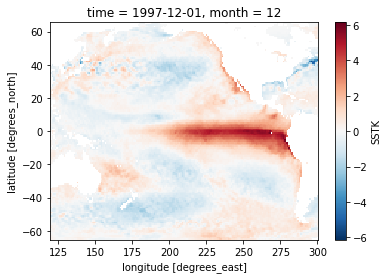

In [17]:
# Plot one month of SST anomalies
anom_SST.sel(time='1997-12-01', method='nearest').plot()

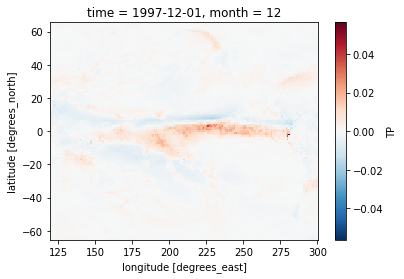

In [18]:
# Plot one month of precip anomalies
anom_precip.sel(time='1997-12-01', method='nearest').plot()

# Problem 2

### Standardize SST

In [7]:
# Calculate the standardized anomaly of SSTs for each month by subtracting the 
# mean and dividing by the standard deviation
mean_SST = ds_SST.groupby("time.month").mean("time")
std_SST = ds_SST.groupby("time.month").std("time")
standardized_SST = xr.apply_ufunc(
    lambda x, m, s: (x - m) / s,
    ds_SST.groupby("time.month"),
    mean_SST,
    std_SST,
)

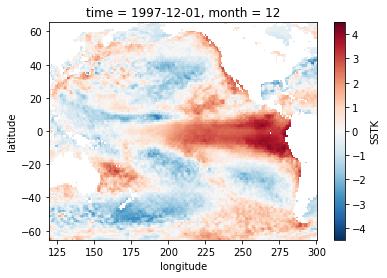

In [8]:
# Plot one month of standardized anomalies
standardized_SST['SSTK'].sel(time='1997-12-01').plot()

### Detrend SST

In [9]:
# Define function to detrend data
def detrend_dim(da, dim, deg=1):
    # detrend along a single dimension
    p = da.polyfit(dim=dim, deg=deg)
    fit = xr.polyval(da[dim], p.polyfit_coefficients)
    return da - fit

# Run the detrend function
detrend_SST = detrend_dim(standardized_SST['SSTK'],'time',1)

#### Example Plot

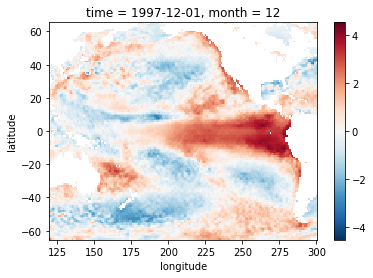

In [58]:
# Plot one month of detrended anomalies
detrend_SST.sel(time='1997-12-01', method='nearest').plot()

### Standardize Precip

In [59]:
# Calculate the standardized anomaly of precip for each month by subtracting 
# the mean and dividing by the standard deviation
mean_precip = ds_precip.groupby("time.month").mean("time")
std_precip = ds_precip.groupby("time.month").std("time")
standardized_precip = xr.apply_ufunc(
    lambda x, m, s: (x - m) / s,
    ds_precip.groupby("time.month"),
    mean_precip,
    std_precip,
)

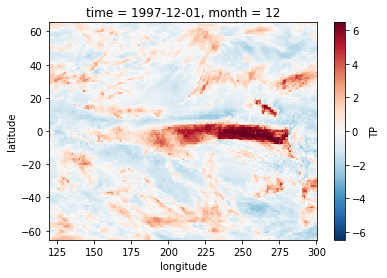

In [60]:
# Plot one month of standardized anomalies
standardized_precip['TP'].sel(time='1997-12-01').plot()

### Detrend Precip

In [61]:
# Define function to detrend data
def detrend_dim(da, dim, deg=1):
    # detrend along a single dimension
    p = da.polyfit(dim=dim, deg=deg)
    fit = xr.polyval(da[dim], p.polyfit_coefficients)
    return da - fit

# Run the detrend function
detrend_precip = detrend_dim(standardized_precip['TP'],'time',1)

#### Example Plot

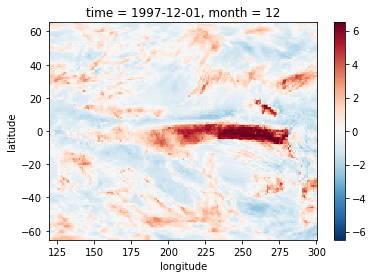

In [62]:
# Plot one month of detrended anomalies
detrend_precip.sel(time='1997-12-01', method='nearest').plot()

# Problem 3

In [17]:
# Create an EOF solver to do the EOF analysis. Square-root of cosine of
# latitude weights are applied before the computation of EOFs.
coslat = np.cos(np.deg2rad(detrend_SST.coords['latitude'].values))
wgts = np.sqrt(coslat)[..., np.newaxis]
solver = Eof(detrend_SST, weights=wgts)

In [18]:
# Save the first 5 eofs as a dataset
eofs = solver.eofs(neofs=5)

Text(0.5, 1.0, 'EOF5')

/Users/ecwolff3/opt/anaconda3/envs/py3/lib/python3.10/site-packages/cartopy/mpl/style.py:76: UserWarning: facecolor will have no effect as it has been defined as "never".
  warnings.warn('facecolor will have no effect as it has been '


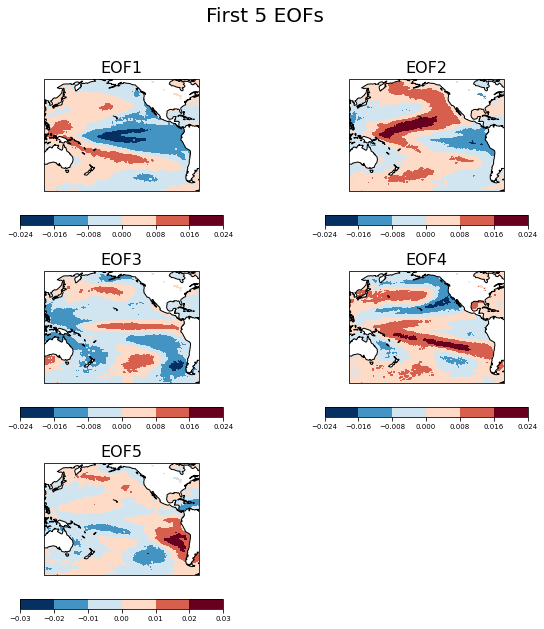

In [19]:
# Plot the first five eofs as individual maps
fig = plt.figure(figsize=(10, 10))
# Add main title
plt.suptitle('First 5 EOFs', fontsize=20)
# Plot first eof
ax1 = plt.subplot(3,2,1, projection=ccrs.PlateCarree(central_longitude=190))
fill1 = eofs[0].plot.contourf(ax=ax1, cmap=plt.cm.RdBu_r,
                             add_colorbar=False, transform=ccrs.PlateCarree())
ax1.add_feature(cfeature.COASTLINE, color='k', edgecolor='k')
cb = plt.colorbar(fill1, orientation='horizontal', shrink=0.8)
#cb.set_label('correlation coefficient', fontsize=12)
cb.ax.tick_params(labelsize=7)
ax1.set_title('EOF1', fontsize=16)

# Plot second eof
ax2 = plt.subplot(3,2,2, projection=ccrs.PlateCarree(central_longitude=190))
fill2 = eofs[1].plot.contourf(ax=ax2, cmap=plt.cm.RdBu_r,
                             add_colorbar=False, transform=ccrs.PlateCarree())
ax2.add_feature(cfeature.COASTLINE, color='k', edgecolor='k')
cb = plt.colorbar(fill2, orientation='horizontal', shrink=0.8)
#cb.set_label('correlation coefficient', fontsize=12)
cb.ax.tick_params(labelsize=7)
ax2.set_title('EOF2', fontsize=16)

# Plot third eof
ax3 = plt.subplot(3,2,3, projection=ccrs.PlateCarree(central_longitude=190))
fill3 = eofs[2].plot.contourf(ax=ax3, cmap=plt.cm.RdBu_r,
                             add_colorbar=False, transform=ccrs.PlateCarree())
ax3.add_feature(cfeature.COASTLINE, color='k', edgecolor='k')
cb = plt.colorbar(fill3, orientation='horizontal', shrink=0.8)
#cb.set_label('correlation coefficient', fontsize=12)
cb.ax.tick_params(labelsize=7)
ax3.set_title('EOF3', fontsize=16)

# Plot fourth eof
ax4 = plt.subplot(3,2,4, projection=ccrs.PlateCarree(central_longitude=190))
fill4 = eofs[3].plot.contourf(ax=ax4, cmap=plt.cm.RdBu_r,
                             add_colorbar=False, transform=ccrs.PlateCarree())
ax4.add_feature(cfeature.COASTLINE, color='k', edgecolor='k')
cb = plt.colorbar(fill4, orientation='horizontal', shrink=0.8)
#cb.set_label('correlation coefficient', fontsize=12)
cb.ax.tick_params(labelsize=7)
ax4.set_title('EOF4', fontsize=16)

# Plot fifth eof
ax5 = plt.subplot(3,2,5, projection=ccrs.PlateCarree(central_longitude=190))
fill5 = eofs[4].plot.contourf(ax=ax5, cmap=plt.cm.RdBu_r,
                             add_colorbar=False, transform=ccrs.PlateCarree())
ax5.add_feature(cfeature.COASTLINE, color='k', edgecolor='k')
cb = plt.colorbar(fill5, orientation='horizontal', shrink=0.8)
#cb.set_label('correlation coefficient', fontsize=12)
cb.ax.tick_params(labelsize=7)
ax5.set_title('EOF5', fontsize=16)

# Problem 4

In [20]:
# Call function to calculate fraction of variance explained by each eof
varfrac = solver.varianceFraction()

(2.559859448672515e-31, 18.66484861395677)

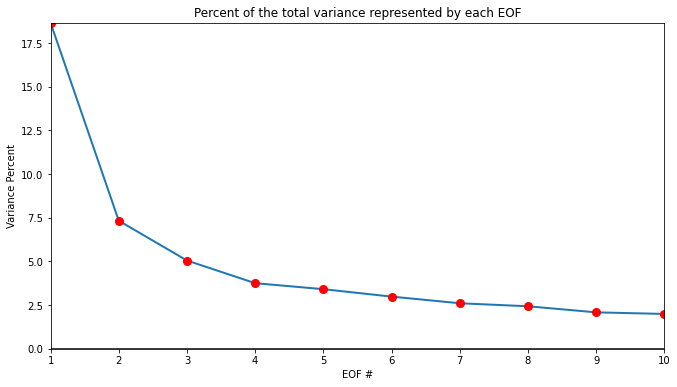

In [21]:
# Plot the percent of variance explained by each EOF
plt.figure(figsize=(11,6))
eof_num = range(1, 11)
plt.plot(eof_num, varfrac[0:10]*100, linewidth=2)
plt.plot(eof_num, varfrac[0:10]*100, linestyle='None', marker="o", color='r', 
            markersize=8)
plt.axhline(0, color='k')
plt.xticks(range(1, 11))
plt.title('Percent of the total variance represented by each EOF')
plt.xlabel('EOF #')
plt.ylabel('Variance Percent')
plt.xlim(1, 10)
plt.ylim(np.min(varfrac)*100, (np.max(varfrac)*100)+0.01)

# Problem 5

In [70]:
# Call function to reconstruct original dataset using the first five eofs
reconstruction = solver.reconstructedField(5)
reconstruction

In [ ]:
# Calculate the correlation between the original data and the reconstructed 
# data
correlation = xr.corr(reconstruction, detrend_SST, dim='time')

In [ ]:
# Plot this correlation
correlation.plot()

# Problem 6

In [ ]:
# Call function to reconstruct original dataset using the first eof only
reconstruction_1 = solver.reconstructedField(1)

In [ ]:
# Calculate the correlation between the detrended and standardized precip data
# and the reconstructed SST data
precip_corr = xr.corr(reconstruction_1, detrend_precip, dim='time')

In [ ]:
# Plot this correlation
precip_corr.plot()

In [15]:
# Shut down dask client
client.close()